# CST example

A Continuous Stirred Tank to be identified from input-output data

In [1]:
import numpy as np
from sklearn.pipeline import Pipeline

from sippy_unipi.datasets import gen_rw_seq, generate_inputs, white_noise
from sippy_unipi.io import ARMAX, ARX, BJ, GEN, OE
from sippy_unipi.plot import plot_comparison
from sippy_unipi.preprocessing import StandardScaler
from sippy_unipi.ss import ParsimK

seed = 0
np.random.seed(seed)

%load_ext autoreload
%autoreload 2

In [2]:
ts = 1.0  # [min]
t_end = 1000
n_samples = int(t_end // ts) + 1
time = np.linspace(0, t_end, n_samples)

## Data

## 4 Inputs

### Manipulated Variables
- Input Flow rate $ F_{in} $ [$ m^3/min $]
- Steam Flow rate $ W $ [$ kg/min $]

### Disturbances
- Input Concentration $ C_{a,in} $ [$ kg $ salt/$ m^3 $ solution]
- Input Temperature $ T_{in} $ [$ °C $]

Where $ U = [F, W, C_{a,in}, T_{in}] $

In [3]:
n_inputs = 4

## 2 Outputs

### Output Variables
- Output Concentration $ C_a $ [$ kg $ salt/$ m^3 $ solution]  ($ C_a = C_{a,out} $)
- Output Temperature $ T $ [$ °C $]  ($ T = T_{out} $)

Where $ X = [C_a, T] $

In [4]:
n_outputs = 2

Build input sequences

In [5]:
U = np.zeros((n_samples, n_inputs))

Manipulated inputs as Generalized Binary Noise (GBN)
- Input Flow rate $F_{in} = F = U[0]$ [$m^3/min$]
- Steam Flow rate $W = U[1]$ [$kg/min$]

In [6]:
prob_switch = 0.05
F_min = 0.4
F_max = 0.6
Range_GBN_1 = (F_min, F_max)
W_min = 20
W_max = 40
Range_GBN_2 = (W_min, W_max)
U[:, :2] = generate_inputs(
    n_samples,
    [Range_GBN_1, Range_GBN_2],
    switch_probability=prob_switch,
    seed=seed,
)

disturbance inputs as RW (random-walk)

Input Concentration Ca_in = U[2]  [kg salt/m^3 solution]

In [7]:
Ca_0 = 10.0  # initial condition
sigma_Ca = 0.01  # variation
U[:, 2] = gen_rw_seq(n_samples, Ca_0, sigma=sigma_Ca, seed=seed)
# Input Temperature T_in            [°C]
Tin_0 = 25.0  # initial condition
sigma_T = 0.01  # variation
U[:, 3] = gen_rw_seq(n_samples, Tin_0, sigma=sigma_T, seed=seed)

## Simulation

In [8]:
class ContinuousStirredTankReactor:
    def __init__(self, dt=1, V=10.0, ro=1100.0, cp=4.180, Lam=2272.0):
        """Initialize the Continuous Stirred Tank Reactor model.

        Args:
            V (float): Tank volume [m^3]
            ro (float): Solution density [kg/m^3]
            cp (float): Specific heat [kJ/kg*K]
            Lam (float): Latent heat [kJ/kg]
        """
        self.dt = dt
        self.V = V
        self.ro = ro
        self.cp = cp
        self.Lam = Lam

        self.n_inputs_ = 4
        self.n_outputs_ = 2

    def dynamics(self, x, u):
        """Model the dynamics of a continuous stirred tank reactor.

        Implements the nonlinear system dynamics for a CSTR with constant volume.

        Args:
            x (np.ndarray): State vector [C_a, T]
            u (np.ndarray): Input vector [F, W, C_a_in, T_in]

        Returns:
            dx/dt (np.ndarray): State derivative vector [dC_a/dt, dT/dt]
        """
        C_a, T = x
        F, W, C_a_in, T_in = u

        # self.V is constant ---> perfect Level Control
        # self.ro*F_in = self.ro*F_out = self.ro*F --> F = F_in = F_out at each instant

        # Mass Balance on A
        dx_0 = (C_a_in * F - C_a * F) / self.V

        # Energy Balance
        dx_1 = (
            self.ro * self.cp * F * T_in
            - self.ro * self.cp * F * T
            + W * self.Lam
        ) / (self.V * self.ro * self.cp)

        dxdt = np.append(dx_0, dx_1)
        return dxdt

    def get_initial_state(self, u0: np.ndarray) -> np.ndarray:
        """Get the initial state of the CSTR.

        Args:
            u0 (np.ndarray): Input vector [F, W, C_a_in, T_in]

        Returns:
            np.ndarray: Initial state [C_a, T]
        """
        F, W, C_a_in, T_in = u0
        Ca_0 = C_a_in
        Tout_0 = (self.ro * self.cp * F * T_in + W * self.Lam) / (
            self.ro * self.cp * F
        )
        return np.array([Ca_0, Tout_0])

    def predict(
        self, U: np.ndarray, x0: np.ndarray | None = None
    ) -> np.ndarray:
        """Predict the output of the CSTR.

        Args:
            U (np.ndarray): Input vector [F, W, C_a_in, T_in]

        Returns:
            np.ndarray: Output vector [C_a, T]
        """
        X = np.zeros((n_samples, self.n_outputs_))
        X[0] = self.get_initial_state(U[0]) if x0 is None else x0

        for j in range(n_samples - 1):
            # Explicit Runge-Kutta 4 (TC dynamics is integrateed by hand)
            Mx = 5  # Number of elements in each time step
            dt = ts / Mx  # integration step
            # Output & Input
            x_k = X[j, :]
            u_k = U[j, :]

            # Integrate the model
            k1 = self.dynamics(x_k, u_k)
            k2 = self.dynamics(x_k + dt / 2.0 * k1, u_k)
            k3 = self.dynamics(x_k + dt / 2.0 * k2, u_k)
            k4 = self.dynamics(x_k + dt * k3, u_k)
            x_next = x_k + (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
            X[j + 1, :] = x_next

        return X


## Run Simulation

In [9]:
cstr = ContinuousStirredTankReactor()
X = cstr.predict(U)

Add noise (with assigned variances)

In [10]:
var = 0.001
noise = white_noise(var, (n_samples, 2), seed=seed)
Y = X + noise

## Identification Stage

In [11]:
na = 2
nb = [1, 1, 1, 1]
nc = 1
nd = 1
nf = 2
theta = [1, 1, 1, 1]
# Number of iterations
max_iter = 300

In [24]:
models = [
    ARX(
        na,
        nb,
        theta,
        max_iter=max_iter,
    ),
    ARMAX(
        na,
        nb,
        nc,
        theta,
        max_iter=max_iter,
    ),
    OE(
        nb,
        nf,
        theta,
        max_iter=max_iter,
    ),
    BJ(
        nb=nb,
        nc=nc,
        nd=nd,
        nf=nf,
        max_iter=max_iter,
    ),
    GEN(
        na,
        nb,
        nc,
        nd,
        nf,
        max_iter=max_iter,
    ),
    ParsimK(2),
]
models = [
    Pipeline([("scaler", StandardScaler(with_mean=False)), ("model", model)])
    for model in models
]

Ys = {"Original": Y}
for model in models:
    model.fit(U, Y)
    Ys[model.steps[1][1].__class__.__name__] = model.predict(U)

## Plot

Inputs

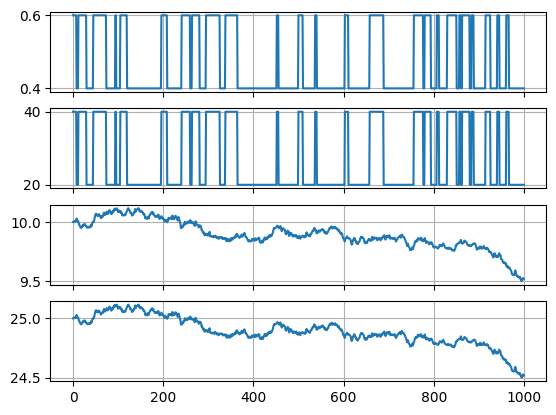

In [25]:
fig = plot_comparison(
    time,
    U,
    [
        "$F [m^3/min]$",
        "$W [kg/min]$",
        "$C_{a_{in}} [kg/m^3]$",
        r"$T_{in} [^\circ{}C]$",
    ],
)

Outputs

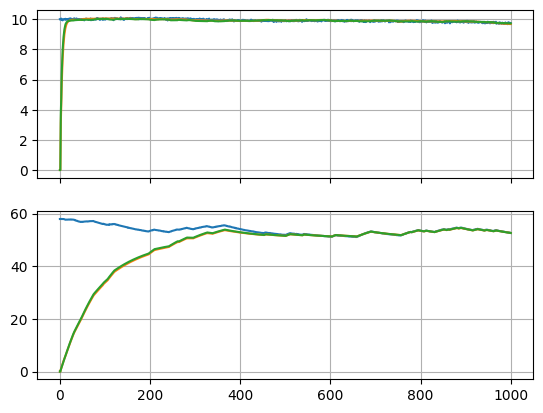

In [26]:
fig = plot_comparison(
    time,
    list(Ys.values())[0:3],
    ["$Ca [kg/m^3]$", r"$T [^\circ{}C]$"],
    legend=list(Ys.keys()),
)

## Validation

In [27]:
U_val = np.zeros((n_samples, n_inputs))

manipulated inputs as GBN<br>
Input Flow rate Fin = F = U[0]    [m^3/min]

In [28]:
U_val[:, :2] = generate_inputs(
    n_samples,
    [Range_GBN_1, Range_GBN_2],
    switch_probability=prob_switch,
    seed=seed,
)

disturbance inputs as RW (random-walk)<br>
Input Concentration Ca_in = U[2]  [kg salt/m^3 solution]

In [29]:
Ca_0 = 10.0  # initial condition
sigma_Ca = 0.02  # variation
U_val[:, 2] = gen_rw_seq(n_samples, Ca_0, sigma=sigma_Ca, seed=seed)
# Input Temperature T_in            [°C]
Tin_0 = 25.0  # initial condition
sigma_T = 0.1  # variation
U_val[:, 3] = gen_rw_seq(n_samples, Tin_0, sigma=sigma_T, seed=seed)

COLLECT DATA

In [30]:
cstr = ContinuousStirredTankReactor()
X_val = cstr.predict(U_val)

Add noise (with assigned variances)

In [31]:
var = [0.01, 0.05]
noise = white_noise(var, (n_samples, 2), seed=seed)
Y_val = X_val + noise

In [32]:
Ys_val = {"Original": Y_val}
for model in models:
    Ys_val[model.steps[1][1].__class__.__name__] = model.predict(U_val)

PLOTS

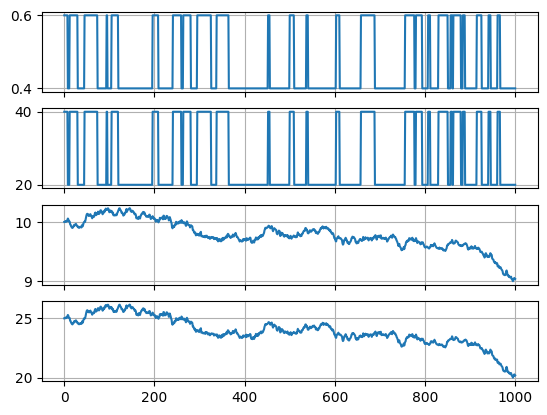

In [33]:
fig = plot_comparison(
    time,
    U_val,
    [
        "$F [m^3/min]$",
        "$W [kg/min]$",
        "$C_{a_{in}} [kg/m^3]$",
        r"$T_{in} [^\circ{}C]$",
    ],
)

/Users/mw/pyprojects/SIPPY/.venv/lib/python3.12/site-packages/matplotlib/ticker.py:2178: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


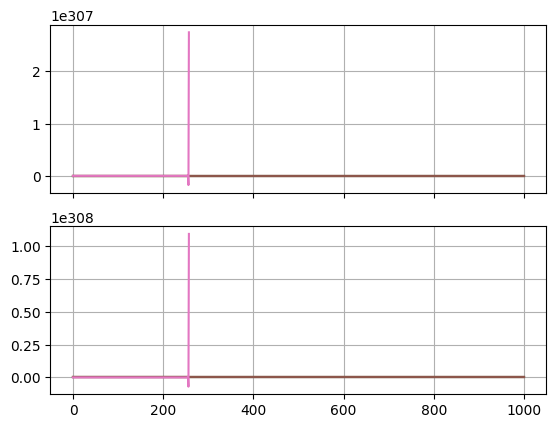

In [34]:
fig = plot_comparison(
    time,
    list(Ys_val.values()),
    ["$Ca [kg/m^3]$", r"$T [^\circ{}C]$"],
    legend=list(Ys_val.keys()),
)